In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import pickle
import tensorflow as tf

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
TRAIN_PATH = 'C:/CompetitionData/stage1_train/'
TEST_PATH = 'C:/CompetitionData/stage1_test/'

X_train_file = 'C:/CompetitionData/X_train.p'
Y_train_file = 'C:/CompetitionData/Y_train.p'
X_test_file = 'C:/CompetitionData/X_test.p'
orig_file_sizes = 'C:/CompetitionData/test_file_sizes.csv'


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
print('Getting resized train, test images and masks ... ')
sys.stdout.flush()

X_train = pickle.load(open(X_train_file, "rb"))
Y_train = pickle.load(open(Y_train_file, "rb"))
X_test = pickle.load(open(X_test_file, "rb"))

print('Done!')
print("shape of train: ", X_train.shape)
print("shape of masks: ", Y_train.shape)
print("shape of test: ", X_test.shape)

Getting resized train, test images and masks ... 
Done!
shape of train:  (670, 256, 256, 1)
shape of masks:  (670, 256, 256, 1)
shape of test:  (65, 256, 256, 1)


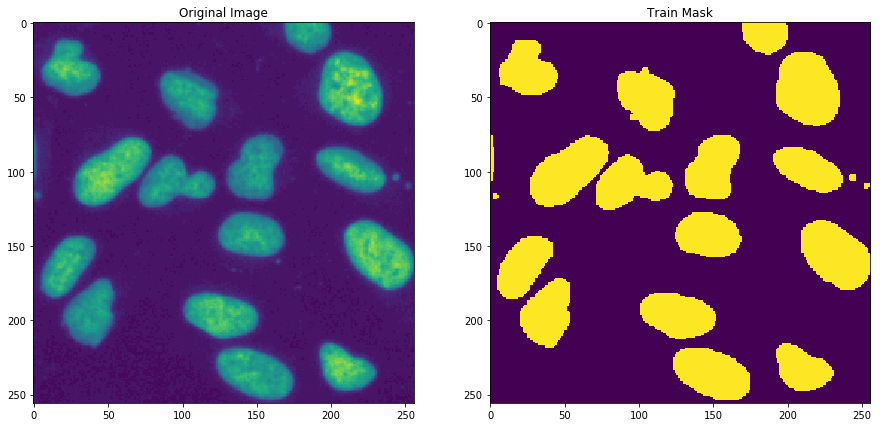

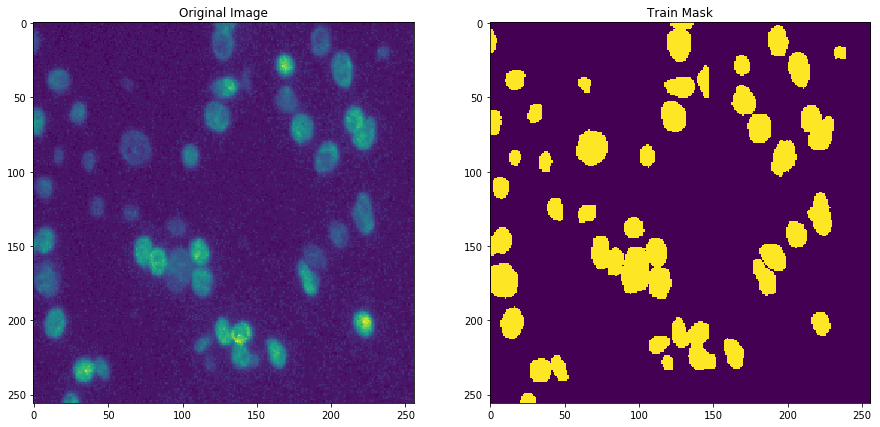

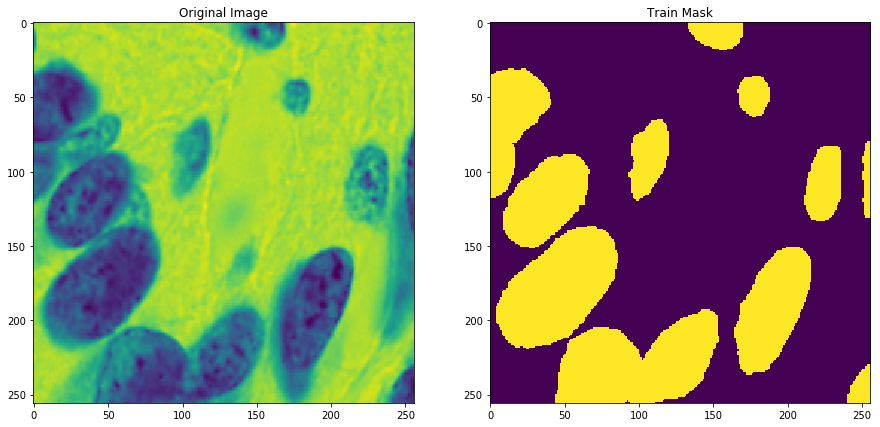

In [4]:
# Check if training data looks all right
for n in range(3):
    ix = random.randint(0, len(X_train))
    f, ax = plt.subplots(1,2,figsize=(15,9))
    ax[0].imshow(np.squeeze(X_train[ix]))
    ax[0].set_title('Original Image')
    ax[1].imshow(np.squeeze(Y_train[ix]))
    ax[1].set_title('Train Mask')
    plt.show()

In [5]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [6]:
def my_iou_binary(y_true, y_pred):
   
    NUM_CLASSES = 2
    score, up_opt = tf.metrics.mean_iou(y_true, y_pred, NUM_CLASSES)
    K.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    return score

In [7]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [8]:
def calculate_iou_tf(model, generator, steps, num_classes):
    conf_m = K.tf.zeros((num_classes, num_classes), dtype=K.tf.float64)
    generator.reset()
    pb = Progbar(steps)
    for i in range(0, steps):
        x, y_true = generator.next()
        y_pred = model.predict_on_batch(x)

        # num_classes = K.int_shape(y_pred)[-1]
        y_pred = K.flatten(K.argmax(y_pred, axis=-1))
        y_true = K.reshape(y_true, (-1,))

        mask = K.less_equal(y_true, num_classes - 1)
        y_true = K.tf.to_int32(K.tf.boolean_mask(y_true, mask))
        y_pred = K.tf.to_int32(K.tf.boolean_mask(y_pred, mask))

        mIoU, up_op = K.tf.contrib.metrics.streaming_mean_iou(y_pred, y_true, num_classes, updates_collections=[conf_m])
        K.get_session().run(K.tf.local_variables_initializer())
        with K.tf.control_dependencies([up_op]):
            score = K.eval(mIoU)
            print(score)

        pb.update(i + 1)

    conf_m = K.eval(conf_m)
    return conf_m, K.eval(mIoU)

In [9]:
# Metric function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    smooth = 1
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Loss funtion
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [10]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[my_iou_binary])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 256, 256, 16) 4624        concatenate_4[0][0]              
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256, 16) 0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 256, 256, 16) 2320        dropout_9[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 1)  17          conv2d_18[0][0]                  
Total params: 1,940,817
Trainable params: 1,940,817
Non-trainable params: 0
__________________________________________________________________________________________________


In [11]:
# Fit model
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=16, epochs=50, shuffle=True, 
    callbacks=[earlystopper, checkpointer])
#results = model.fit_generator(train_generator, steps_per_epoch=len(X_train_tr), epochs=10,
 #                             shuffle=True,
  #                            validation_data=val_generator,
   #                           validation_steps=len(X_train_val),
    #                         callbacks=[earlystopper,checkpointer])

Train on 536 samples, validate on 134 samples
Epoch 1/50
536/536 [==============================] - 29s 54ms/step - loss: 0.5254 - my_iou_binary: 0.4162 - val_loss: 0.3885 - val_my_iou_binary: 0.4255
Epoch 2/50
536/536 [==============================] - 23s 44ms/step - loss: 0.3063 - my_iou_binary: 0.4253 - val_loss: 0.2418 - val_my_iou_binary: 0.4259
Epoch 3/50
536/536 [==============================] - 24s 44ms/step - loss: 0.2338 - my_iou_binary: 0.4264 - val_loss: 0.1845 - val_my_iou_binary: 0.4260
Epoch 4/50
536/536 [==============================] - 24s 44ms/step - loss: 0.1726 - my_iou_binary: 0.4263 - val_loss: 0.2288 - val_my_iou_binary: 0.4261
Epoch 5/50


536/536 [==============================] - 24s 44ms/step - loss: 0.1364 - my_iou_binary: 0.4262 - val_loss: 0.1125 - val_my_iou_binary: 0.4261
Epoch 6/50
536/536 [==============================] - 24s 45ms/step - loss: 0.1224 - my_iou_binary: 0.4263 - val_loss: 0.0975 - val_my_iou_binary: 0.4261
Epoch 7/50
536/536 [==============================] - 24s 44ms/step - loss: 0.1212 - my_iou_binary: 0.4262 - val_loss: 0.1101 - val_my_iou_binary: 0.4261
Epoch 8/50
536/536 [==============================] - 24s 44ms/step - loss: 0.1207 - my_iou_binary: 0.4262 - val_loss: 0.1007 - val_my_iou_binary: 0.4261
Epoch 9/50


536/536 [==============================] - 24s 45ms/step - loss: 0.1131 - my_iou_binary: 0.4262 - val_loss: 0.0959 - val_my_iou_binary: 0.4262
Epoch 10/50
536/536 [==============================] - 24s 45ms/step - loss: 0.1161 - my_iou_binary: 0.4262 - val_loss: 0.0944 - val_my_iou_binary: 0.4262
Epoch 11/50
536/536 [==============================] - 24s 45ms/step - loss: 0.1050 - my_iou_binary: 0.4261 - val_loss: 0.0843 - val_my_iou_binary: 0.4262
Epoch 12/50
536/536 [==============================] - 24s 45ms/step - loss: 0.1041 - my_iou_binary: 0.4262 - val_loss: 0.0884 - val_my_iou_binary: 0.4262
Epoch 13/50


536/536 [==============================] - 24s 44ms/step - loss: 0.1032 - my_iou_binary: 0.4262 - val_loss: 0.0866 - val_my_iou_binary: 0.4262
Epoch 14/50
536/536 [==============================] - 24s 45ms/step - loss: 0.1030 - my_iou_binary: 0.4262 - val_loss: 0.0861 - val_my_iou_binary: 0.4262
Epoch 15/50
536/536 [==============================] - 24s 45ms/step - loss: 0.0999 - my_iou_binary: 0.4262 - val_loss: 0.0816 - val_my_iou_binary: 0.4262
Epoch 16/50
536/536 [==============================] - 24s 45ms/step - loss: 0.1020 - my_iou_binary: 0.4262 - val_loss: 0.0862 - val_my_iou_binary: 0.4262
Epoch 17/50


536/536 [==============================] - 24s 45ms/step - loss: 0.0974 - my_iou_binary: 0.4262 - val_loss: 0.0739 - val_my_iou_binary: 0.4262
Epoch 18/50
536/536 [==============================] - 24s 45ms/step - loss: 0.0951 - my_iou_binary: 0.4262 - val_loss: 0.0786 - val_my_iou_binary: 0.4262
Epoch 19/50
536/536 [==============================] - 24s 45ms/step - loss: 0.0920 - my_iou_binary: 0.4262 - val_loss: 0.0754 - val_my_iou_binary: 0.4262
Epoch 20/50
536/536 [==============================] - 24s 45ms/step - loss: 0.0921 - my_iou_binary: 0.4262 - val_loss: 0.0724 - val_my_iou_binary: 0.4262
Epoch 21/50


536/536 [==============================] - 24s 45ms/step - loss: 0.0882 - my_iou_binary: 0.4263 - val_loss: 0.0715 - val_my_iou_binary: 0.4262
Epoch 22/50
536/536 [==============================] - 24s 45ms/step - loss: 0.0873 - my_iou_binary: 0.4262 - val_loss: 0.0726 - val_my_iou_binary: 0.4262
Epoch 23/50
536/536 [==============================] - 24s 46ms/step - loss: 0.0899 - my_iou_binary: 0.4262 - val_loss: 0.0703 - val_my_iou_binary: 0.4262
Epoch 24/50
536/536 [==============================] - 24s 45ms/step - loss: 0.0854 - my_iou_binary: 0.4262 - val_loss: 0.0690 - val_my_iou_binary: 0.4262
Epoch 25/50


536/536 [==============================] - 24s 45ms/step - loss: 0.0811 - my_iou_binary: 0.4263 - val_loss: 0.0733 - val_my_iou_binary: 0.4262
Epoch 26/50
536/536 [==============================] - 24s 45ms/step - loss: 0.0941 - my_iou_binary: 0.4262 - val_loss: 0.0783 - val_my_iou_binary: 0.4262
Epoch 27/50
536/536 [==============================] - 24s 45ms/step - loss: 0.0846 - my_iou_binary: 0.4262 - val_loss: 0.0703 - val_my_iou_binary: 0.4262
Epoch 28/50
536/536 [==============================] - 24s 45ms/step - loss: 0.0829 - my_iou_binary: 0.4262 - val_loss: 0.0748 - val_my_iou_binary: 0.4262
Epoch 29/50


536/536 [==============================] - 24s 46ms/step - loss: 0.0799 - my_iou_binary: 0.4262 - val_loss: 0.0657 - val_my_iou_binary: 0.4262
Epoch 30/50
536/536 [==============================] - 24s 45ms/step - loss: 0.0802 - my_iou_binary: 0.4262 - val_loss: 0.0692 - val_my_iou_binary: 0.4262
Epoch 31/50
536/536 [==============================] - 24s 45ms/step - loss: 0.0756 - my_iou_binary: 0.4262 - val_loss: 0.0708 - val_my_iou_binary: 0.4262
Epoch 32/50
536/536 [==============================] - 24s 45ms/step - loss: 0.0763 - my_iou_binary: 0.4262 - val_loss: 0.0684 - val_my_iou_binary: 0.4262
Epoch 33/50


536/536 [==============================] - 24s 45ms/step - loss: 0.0773 - my_iou_binary: 0.4262 - val_loss: 0.0745 - val_my_iou_binary: 0.4262
Epoch 34/50
536/536 [==============================] - 24s 45ms/step - loss: 0.0758 - my_iou_binary: 0.4262 - val_loss: 0.0960 - val_my_iou_binary: 0.4262
Epoch 35/50
536/536 [==============================] - 24s 45ms/step - loss: 0.0803 - my_iou_binary: 0.4262 - val_loss: 0.0761 - val_my_iou_binary: 0.4262
Epoch 36/50
536/536 [==============================] - 24s 45ms/step - loss: 0.0757 - my_iou_binary: 0.4262 - val_loss: 0.0705 - val_my_iou_binary: 0.4262
Epoch 37/50


536/536 [==============================] - 24s 45ms/step - loss: 0.0741 - my_iou_binary: 0.4262 - val_loss: 0.0665 - val_my_iou_binary: 0.4262
Epoch 38/50
536/536 [==============================] - 24s 45ms/step - loss: 0.0737 - my_iou_binary: 0.4262 - val_loss: 0.0660 - val_my_iou_binary: 0.4262
Epoch 39/50
536/536 [==============================] - 24s 45ms/step - loss: 0.0762 - my_iou_binary: 0.4262 - val_loss: 0.0662 - val_my_iou_binary: 0.4262
Epoch 00039: early stopping


In [29]:
# Predict on train, val and test
sizes_test = pd.read_csv(orig_file_sizes, index_col=0)
model = load_model('model-dsbowl2018-1.h5', custom_objects={'my_iou_binary': my_iou_binary})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.9).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled, preds_test_upsampled_t = [], []
for i in range(len(preds_test)):
    img = np.squeeze(preds_test[i])
    o_h, o_w = eval(sizes_test.iloc[i]['original_size'])
    
    if (o_h != img.shape[0]) or (o_w != img.shape[1]):
        #image needs to be resized because it doesn't match original size
    
        if (o_h <= IMG_HEIGHT) and (o_w <= IMG_WIDTH):
            #image is smaller than "canvas" size, so clip it (do NOT resize)
            img = img[:o_h,:o_w]
        else:
            #image is larger than "canvas" size, so resize.
            img = resize(img, (o_h, o_w), mode='constant', preserve_range=True)
    
    preds_test_upsampled.append(img)
    preds_test_upsampled_t.append((img > 0.5).astype(np.uint8))
    #preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
    #                                   (sizes_test[i][0], sizes_test[i][1]), 
    #                                   mode='constant', preserve_range=True))

65/65 [==============================] - ETA:  - ETA:  - 1s 9ms/step


In [30]:
np.array(preds_test_upsampled_t).shape

(65,)

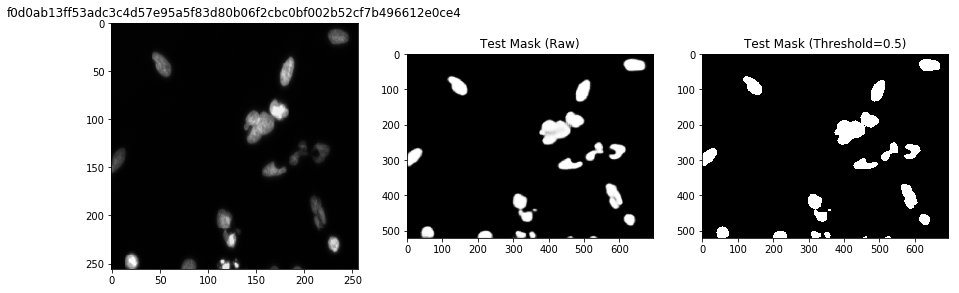

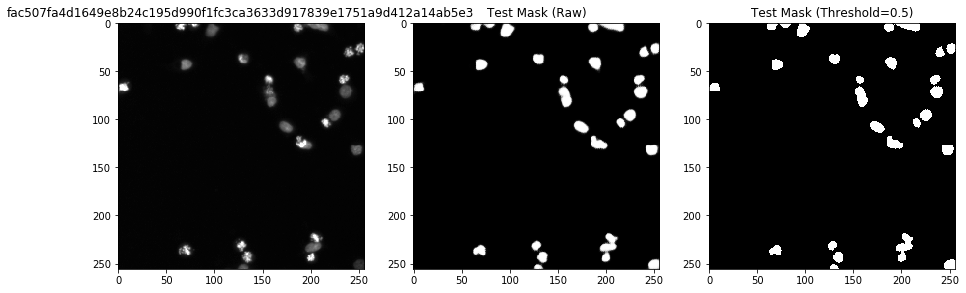

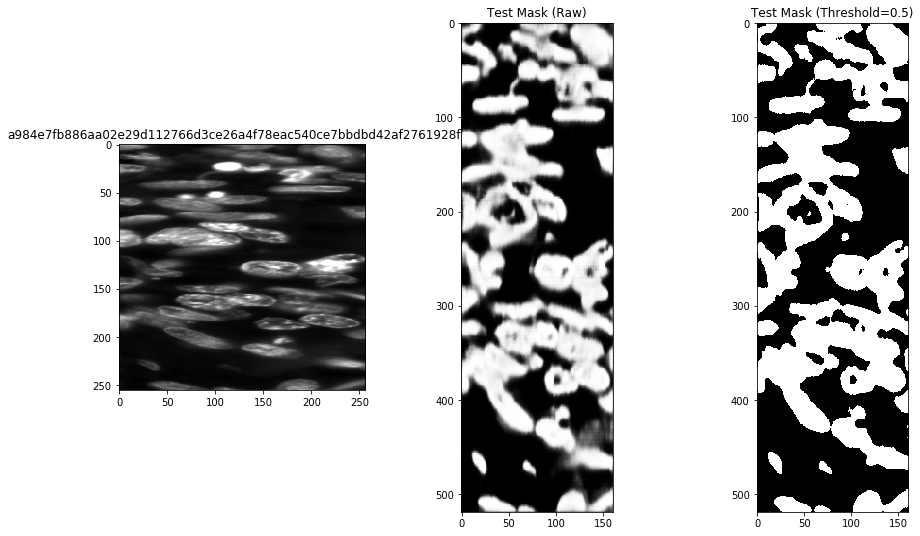

In [31]:
# Check if test data looks all right
for n in range(3):
    ix = random.randint(0, len(X_test))
    f, ax = plt.subplots(1,3,figsize=(15,9))
    ax[0].imshow(np.squeeze(X_test[ix]), cmap="gray")
    ax[0].set_title(sizes_test.iloc[ix]['image_id'])
    ax[1].imshow(np.squeeze(preds_test_upsampled[ix]), cmap="gray")
    ax[1].set_title('Test Mask (Raw)')
    ax[2].imshow(np.squeeze(preds_test_upsampled_t[ix]), cmap="gray")
    ax[2].set_title('Test Mask (Threshold=0.5)')
    plt.show()

In [22]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

#def prob_to_rles(x, cutoff=0.5):
#    lab_img = label(x > cutoff)
def prob_to_rles(x):
    lab_img = label(x >= 0.01)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [23]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled_t[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('submission_THRESHOLD_50.csv', index=False)

In [24]:
## RAW GEN, DON"T NEED
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('submission_RAW.csv', index=False)

In [ ]:
###DON"T NEED THIS
# we create two instances with the same arguments
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90.,
                     horizontal_flip=True,
                     vertical_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(X_train, augment=True)
mask_datagen.fit(Y_train, augment=True)

# Split the train set into validation based on 80/20
X_train_tr, X_train_val, Y_train_tr, Y_train_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=16)
print(X_train_tr.shape)
print(X_train_val.shape)
print(Y_train_tr.shape)
print(Y_train_val.shape)

image_generator = image_datagen.flow(
    X_train_tr)

mask_generator = mask_datagen.flow(
    Y_train_tr)

image_val_generator = image_datagen.flow(X_train_val)

mask_val_generator = mask_datagen.flow(Y_train_val)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)
val_generator = zip(image_val_generator, mask_val_generator)

#model.fit_generator(
#    train_generator,
#    steps_per_epoch=2000,
#    epochs=50)